In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf

# Step 1: Load the dataset

In [2]:
train_set, valid_set, test_set = tfds. load(
    name="caltech101",
    split=["train", "test[50%:]", "test[:50%]"],
    as_supervised=True # Note use of as_supervised=True
)

train_set.cardinality(), valid_set.cardinality(), test_set.cardinality()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3060 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.2.incompleteE1MRSS/caltech101-train.tfrecord*...:   0%|    …

Generating test examples...:   0%|          | 0/6084 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/caltech101/3.0.2.incompleteE1MRSS/caltech101-test.tfrecord*...:   0%|     …

Dataset caltech101 downloaded and prepared to /root/tensorflow_datasets/caltech101/3.0.2. Subsequent calls will reuse this data.


(<tf.Tensor: shape=(), dtype=int64, numpy=3060>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3042>,
 <tf.Tensor: shape=(), dtype=int64, numpy=3042>)

In [3]:
for image, label in train_set.take(1):
  print(image.dtype)
  print(label.dtype)

<dtype: 'uint8'>
<dtype: 'int64'>


# Step 2: Data Exploration

In [4]:
def resize(image, height=224, width=224):
  layer = tf.keras.layers.Resizing(height=height,width=width,crop_to_aspect_ratio=True)
  return layer(image)

train_set = train_set.map(lambda image, label : (resize(image), label))
val_set = valid_set.map(lambda image, label : (resize(image), label))
test_set = test_set.map(lambda image, label : (resize(image), label))

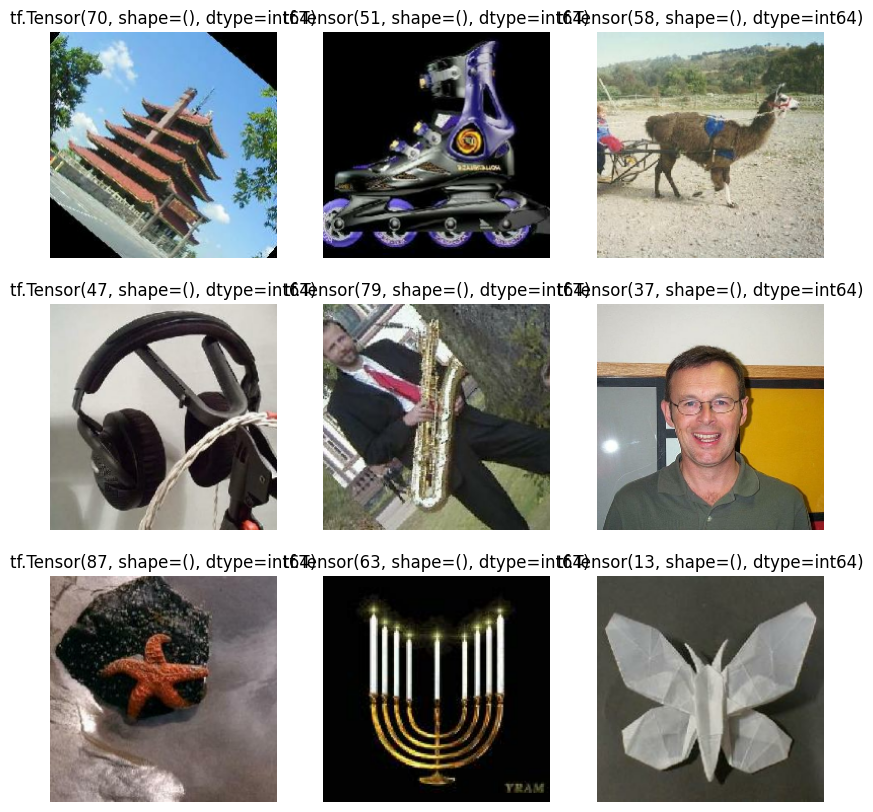

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  for image,label in train_set.take(i+1):
    plt.imshow(image.numpy().astype(np.int32))
    plt.title(str(label))
    plt.axis('off')

# Step 3: Preprocess the Data

In [6]:
def preprocess(images, labels):
  return tf.keras.applications.mobilenet_v2.preprocess_input(images), labels

In [7]:
train_set = train_set.map(preprocess)
val_set = val_set.map(preprocess)
test_set = test_set.map(preprocess)

In [8]:
train_set = train_set.batch(batch_size=32)
val_set = val_set.batch(batch_size=32)
test_set = test_set.batch(batch_size=32)

In [9]:
train_set = train_set.shuffle(buffer_size=1000, seed=42)
train_set = train_set.prefetch(1)

# Step 4: Create a Data Augmentation Layer

In [10]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
  tf.keras.layers.RandomRotation(factor=0.2, seed=42, fill_mode="constant", fill_value=0),
  tf.keras.layers.RandomZoom(height_factor=0.15, seed=42, fill_mode="constant", fill_value=0)
])

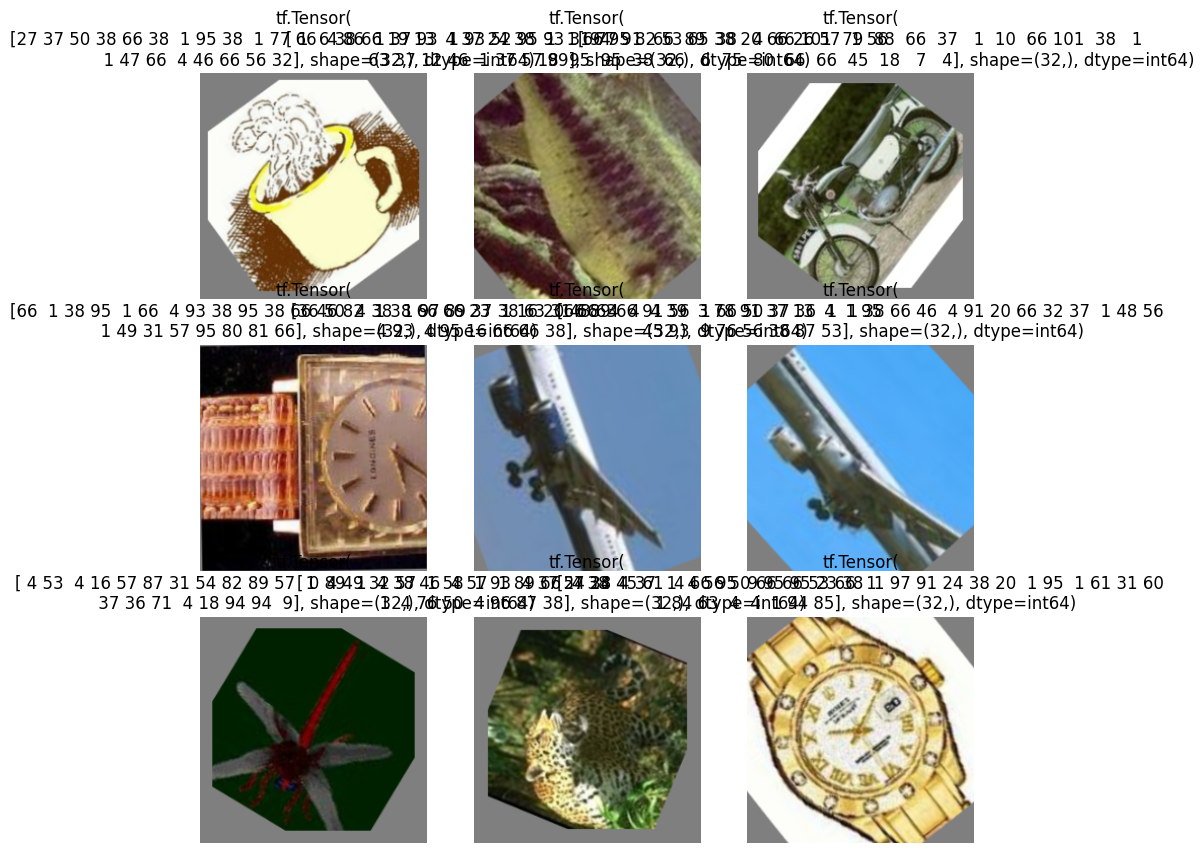

In [11]:
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  for image,label in val_set.take(i+1):
    image = data_augmentation(image)
    plt.imshow((image[i] + 1) / 2)
    plt.title(str(label))
    plt.axis('off')

# Step 5: Load the Base Model

In [23]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
augmented = data_augmentation(input_layer)
base_model_output = base_model(augmented, training=False)

global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
dropout = tf.keras.layers.Dropout(rate=0.4)(global_avg_pooling)
output = tf.keras.layers.Dense(units=102, activation="softmax")(dropout)

model = tf.keras.Model(inputs=[input_layer], outputs=[output])

for layer in base_model.layers:
  layer.trainable = False

In [24]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_1  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_1 (Dropout)         (None, 1280)              0         
                                                                 
 dense_1 (Dense)             (None, 102)               1306

# Step 6: Train the Top Layer of the Model

In [25]:
train_set.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [29]:
escb = tf.keras.callbacks.EarlyStopping(patience=3, monitor="val_accuracy", min_delta=0.001)

history = model.fit(train_set, validation_data=val_set, epochs=100, callbacks=[escb])

Epoch 1/100
96/96 [==============================] - 21s 106ms/step - loss: 3.5321 - accuracy: 0.2458 - val_loss: 1.5715 - val_accuracy: 0.7150
Epoch 2/100
96/96 [==============================] - 10s 89ms/step - loss: 1.4469 - accuracy: 0.6471 - val_loss: 1.0633 - val_accuracy: 0.7656
Epoch 3/100
96/96 [==============================] - 10s 93ms/step - loss: 0.9803 - accuracy: 0.7444 - val_loss: 0.8137 - val_accuracy: 0.8090
Epoch 4/100
96/96 [==============================] - 10s 77ms/step - loss: 0.7738 - accuracy: 0.7928 - val_loss: 0.7550 - val_accuracy: 0.8100
Epoch 5/100
96/96 [==============================] - 9s 80ms/step - loss: 0.6409 - accuracy: 0.8271 - val_loss: 0.7004 - val_accuracy: 0.8271
Epoch 6/100
96/96 [==============================] - 9s 80ms/step - loss: 0.5691 - accuracy: 0.8458 - val_loss: 0.6943 - val_accuracy: 0.8254
Epoch 7/100
96/96 [==============================] - 10s 93ms/step - loss: 0.4932 - accuracy: 0.8621 - val_loss: 0.6333 - val_accuracy: 0.8340


# Step 7: Fine-tune the Model

In [54]:
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")

input_layer = tf.keras.layers.Input(shape=(224, 224, 3))
augmented = data_augmentation(input_layer)
base_model_output = base_model(augmented, training=True)

global_avg_pooling = tf.keras.layers.GlobalAveragePooling2D()(base_model_output)
dropout = tf.keras.layers.Dropout(rate=0.4)(global_avg_pooling)
output = tf.keras.layers.Dense(units=102, activation="softmax")(dropout)

model = tf.keras.Model(inputs=[input_layer], outputs=[output])

In [55]:
for idx, layer in enumerate(base_model.layers):

  if str(layer.name).__contains__("block_13_expand"):
    print(f"{idx}: {layer.name}, {layer}")

116: block_13_expand, <keras.src.layers.convolutional.conv2d.Conv2D object at 0x78e6e7ce7670>
117: block_13_expand_BN, <keras.src.layers.normalization.batch_normalization.BatchNormalization object at 0x78e6e7cf9ff0>
118: block_13_expand_relu, <keras.src.layers.activation.relu.ReLU object at 0x78e6e7c7d240>


In [60]:
for idx, layer in enumerate(base_model.layers):
  if idx >= 116:
    layer.trainable = True
  else:
    layer.trainable = False

### Test om te kijken of het heeft gewerkt

In [ ]:
for idx, layer in enumerate(base_model.layers):
    print(f"{idx}: {layer.name}")
    print((layer.get_config()).get("trainable"))

In [62]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d_2  (None, 1280)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_2 (Dropout)         (None, 1280)              0         
                                                                 
 dense_2 (Dense)             (None, 102)               1306

In [63]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

history = model.fit(train_set, validation_data=val_set, epochs=100, callbacks=[escb])

Epoch 1/100
96/96 [==============================] - 22s 113ms/step - loss: 5.1178 - accuracy: 0.0134 - val_loss: 4.5033 - val_accuracy: 0.0201
Epoch 2/100
96/96 [==============================] - 11s 100ms/step - loss: 4.7405 - accuracy: 0.0232 - val_loss: 4.2493 - val_accuracy: 0.0559
Epoch 3/100
96/96 [==============================] - 13s 108ms/step - loss: 4.4614 - accuracy: 0.0507 - val_loss: 4.0217 - val_accuracy: 0.1141
Epoch 4/100
96/96 [==============================] - 11s 95ms/step - loss: 4.2134 - accuracy: 0.0984 - val_loss: 3.7979 - val_accuracy: 0.1956
Epoch 5/100
96/96 [==============================] - 10s 92ms/step - loss: 3.9948 - accuracy: 0.1330 - val_loss: 3.5795 - val_accuracy: 0.2728
Epoch 6/100
96/96 [==============================] - 12s 107ms/step - loss: 3.7334 - accuracy: 0.1954 - val_loss: 3.3641 - val_accuracy: 0.3379
Epoch 7/100
96/96 [==============================] - 10s 88ms/step - loss: 3.4924 - accuracy: 0.2477 - val_loss: 3.1357 - val_accuracy: 0.

# Step 8: Evaluate the Model

In [65]:
model.evaluate(test_set)

96/96 [==============================] - 4s 40ms/step - loss: 1.0809 - accuracy: 0.7334


[1.0809063911437988, 0.7333990931510925]

# Step 9: Calculate Top-1, Top-3 and Top-5 Accuracy

In [67]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss="sparse_categorical_crossentropy",
              metrics=[
                  "accuracy",
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(k=1, name="top_1_accuracy"),
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(k=3, name="top_3_accuracy"),
                  tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name="top_5_accuracy")
                  ])

history = model.fit(train_set, validation_data=val_set, epochs=100, callbacks=[escb])

Epoch 1/100
96/96 [==============================] - 21s 118ms/step - loss: 0.4780 - accuracy: 0.8944 - top_1_accuracy: 0.8944 - top_3_accuracy: 0.9739 - top_5_accuracy: 0.9856 - val_loss: 1.0357 - val_accuracy: 0.7449 - val_top_1_accuracy: 0.7449 - val_top_3_accuracy: 0.8830 - val_top_5_accuracy: 0.9162
Epoch 2/100
96/96 [==============================] - 12s 104ms/step - loss: 0.4536 - accuracy: 0.9059 - top_1_accuracy: 0.9059 - top_3_accuracy: 0.9778 - top_5_accuracy: 0.9882 - val_loss: 1.0253 - val_accuracy: 0.7475 - val_top_1_accuracy: 0.7475 - val_top_3_accuracy: 0.8843 - val_top_5_accuracy: 0.9175
Epoch 3/100
96/96 [==============================] - 10s 90ms/step - loss: 0.4471 - accuracy: 0.9049 - top_1_accuracy: 0.9049 - top_3_accuracy: 0.9794 - top_5_accuracy: 0.9889 - val_loss: 1.0223 - val_accuracy: 0.7442 - val_top_1_accuracy: 0.7442 - val_top_3_accuracy: 0.8843 - val_top_5_accuracy: 0.9188
Epoch 4/100
96/96 [==============================] - 12s 108ms/step - loss: 0.4354 

In [68]:
model.evaluate(test_set)

96/96 [==============================] - 4s 42ms/step - loss: 0.9708 - accuracy: 0.7521 - top_1_accuracy: 0.7521 - top_3_accuracy: 0.8951 - top_5_accuracy: 0.9290


[0.9707693457603455,
 0.752136766910553,
 0.752136766910553,
 0.8951348066329956,
 0.9289940595626831]